In [53]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm

In [2]:
dfAll = pd.read_csv('birds.csv')
dfAll.head()

,tail,tarsus,hoof,horns,ear,head,withers,length,Weight_corr,TestWeight_corr,...,weight,lengthtotail,testLength,pesotes,kidneyindex,logkfi,raizkfi,method,embryoLength,embryoWeight
0,7.0,12.6,1.7,3.3,4.6,13.1,35.1,55.0,3.75,7.5,...,3.75,62.0,3.2,7.5,20.2,1.3,4.5,Gun,0.0,0.0
1,6.1,12.8,2.1,2.2,4.8,11.8,30.2,47.2,2.42,0.0,...,2.42,53.3,NaN,NaN,12.3,1.1,3.5,Gun,0.0,0.0
2,4.6,14.1,1.8,3.6,4.2,11.8,31.5,54.2,2.79,1.8,...,2.79,58.8,1.7,1.8,NaN,NaN,NaN,Gun,0.0,0.0
3,5.9,14.2,2.1,1.3,4.4,11.3,30.1,48.0,2.22,0.0,...,2.22,53.9,NaN,NaN,35.5,1.6,6.0,Gun,0.0,0.0
4,9.6,14.0,2.0,2.4,4.5,12.8,27.5,51.5,2.88,0.0,...,2.88,61.1,NaN,NaN,2.7,0.6,1.7,Trap,0.0,0.0


In [3]:
# We only need the first 13 columns
dfNumeric = dfAll.iloc[:, :13]

# Standardize all columns
df = (dfNumeric - dfNumeric.mean()) / dfNumeric.std()
df.head()

,tail,tarsus,hoof,horns,ear,head,withers,length,Weight_corr,TestWeight_corr,perifatmass,kmass,kidneyindexcorreg
0,-0.552715,-2.982891,-2.436816,-0.012103,-0.055190,0.448427,1.449387,0.478151,0.861317,1.426911,0.035873,-0.366338,0.185305
1,-1.348564,-2.748895,-0.954204,-1.067205,0.492581,-1.052782,-0.447098,-1.339903,-1.190451,-0.793664,-0.259784,-0.487891,-0.203266
2,-2.674978,-1.227925,-2.066163,0.275653,-1.150730,-1.052782,0.056051,0.291684,-0.619659,-0.260726,-0.259784,-0.649962,-0.036033
3,-1.525419,-1.110927,-0.954204,-1.930471,-0.602960,-1.630171,-0.485802,-1.153436,-1.498988,-0.793664,0.247057,-1.257728,0.937852
4,1.746405,-1.344923,-1.324857,-0.875368,-0.329075,0.101994,-1.492100,-0.337642,-0.480817,-0.793664,-0.597679,-0.812033,-0.675452


In [35]:
# looking at the data before choosing what should be clustered
def pairplot(df):
    sns.pairplot(df, corner=True)
    plt.show()
    return

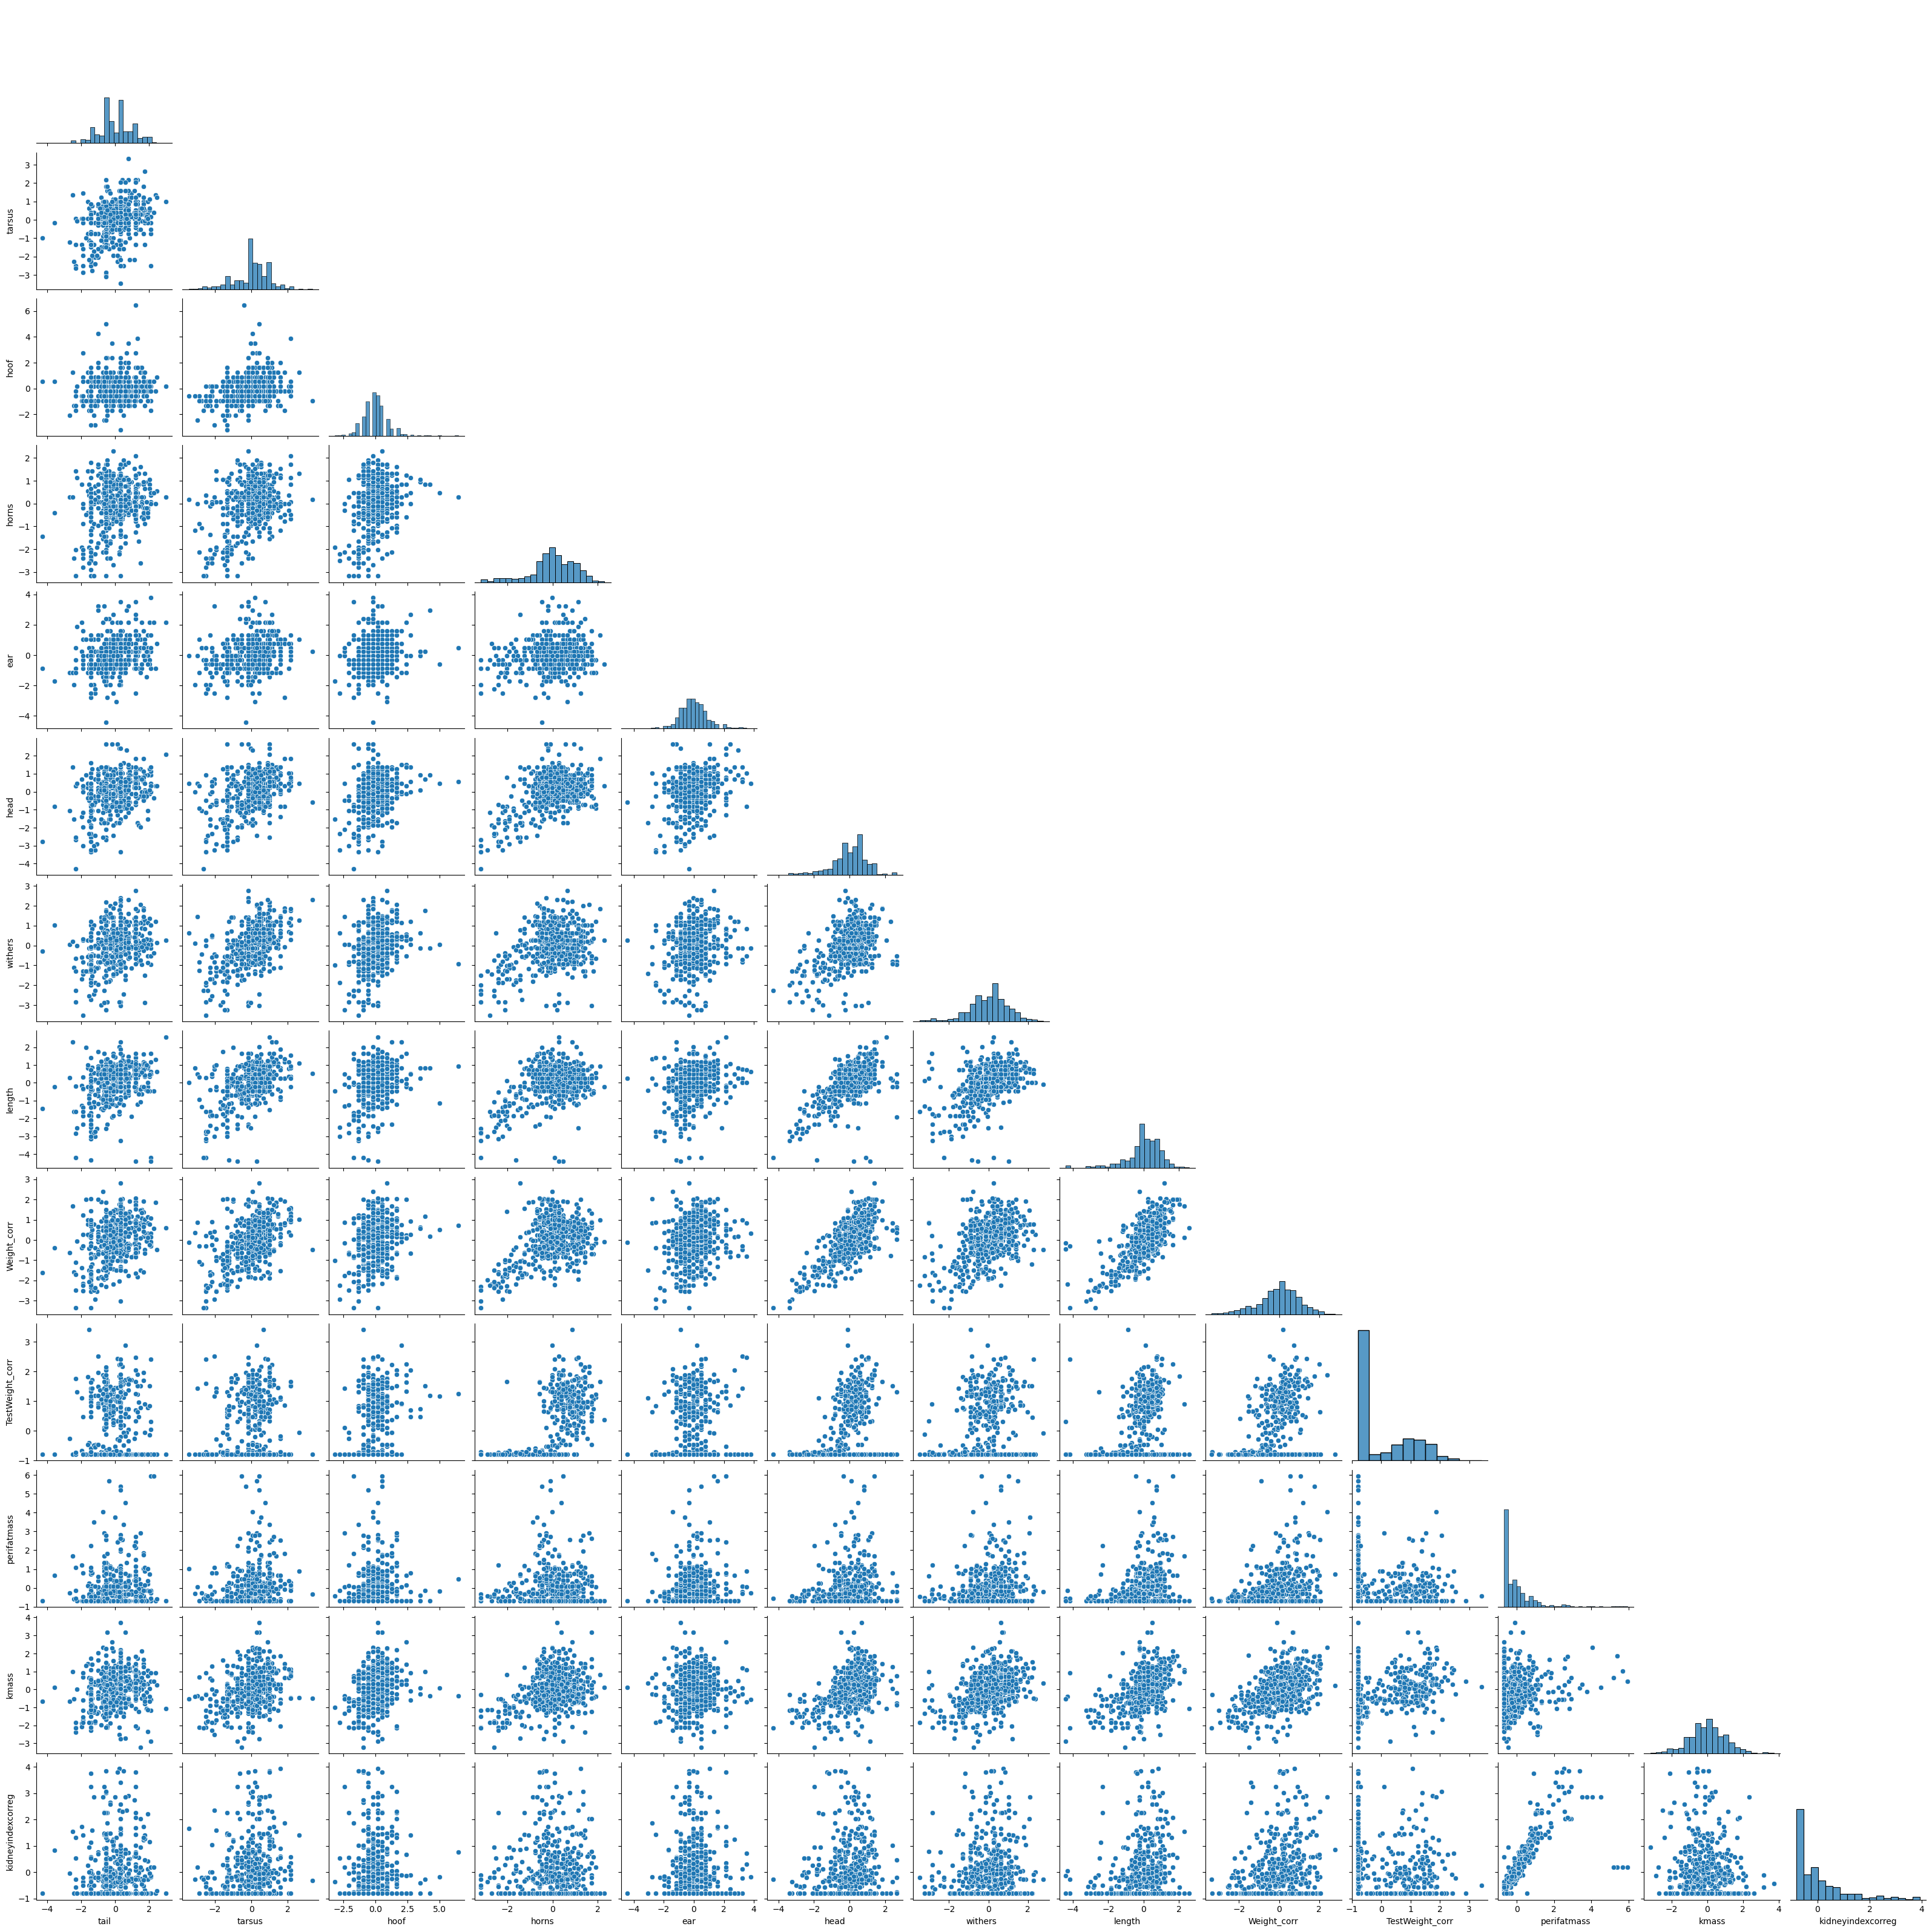

In [37]:
pairplot(df)

In [31]:
def heatmap(df):
    fig, ax = plt.subplots(figsize = (12, 10))
    mask = np.triu(np.ones_like(df.corr()))
    sns.heatmap(df.corr(), ax = ax, vmin = -1, vmax = 1, cmap = 'RdBu', annot = True, mask = mask)
    plt.show()
    return

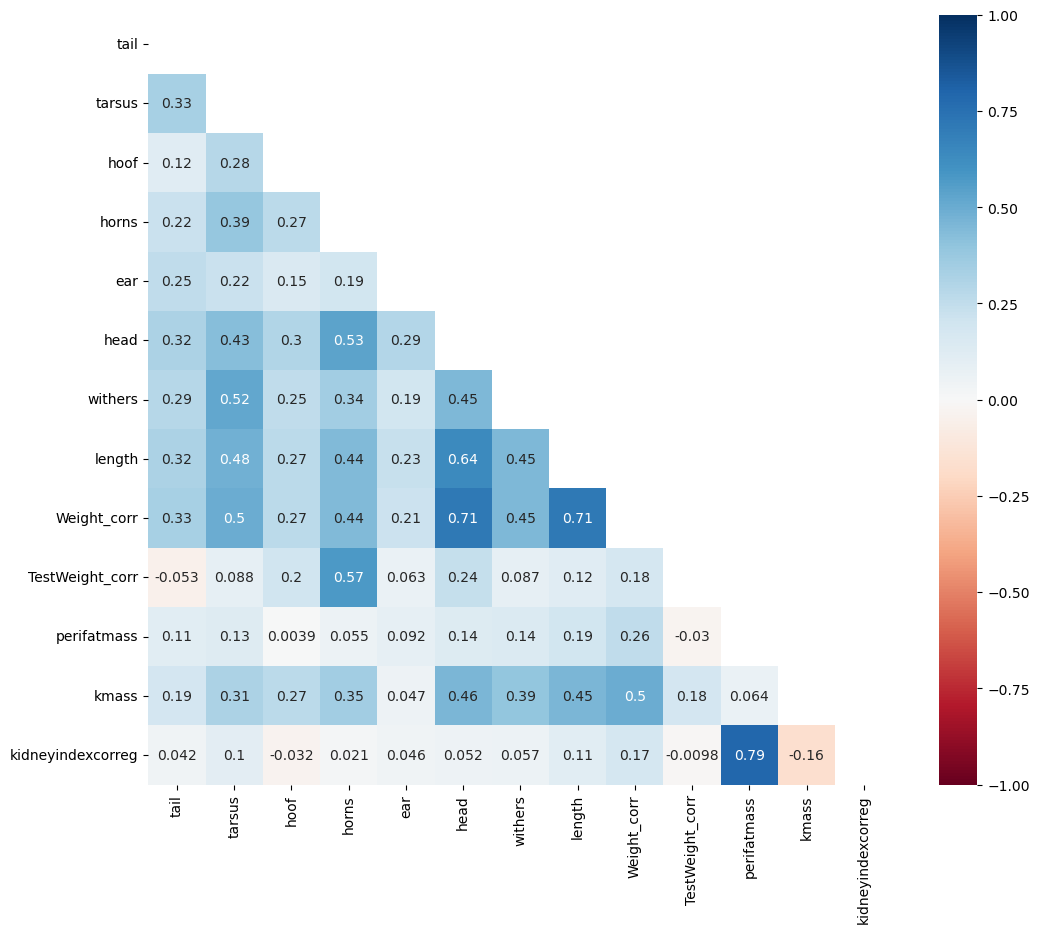

In [33]:
heatmap(df)

To view graphically the number of clusters we should use, we can compute the elbow method.

In [7]:
def elbowPlot(df, ini, end):
    inertia = []
    for k in range(ini, end):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        
    plt.plot(range(ini, end), inertia)
    plt.xlabel('Number of clusters', fontsize = 14)
    plt.ylabel('Inertia', fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()
    return

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

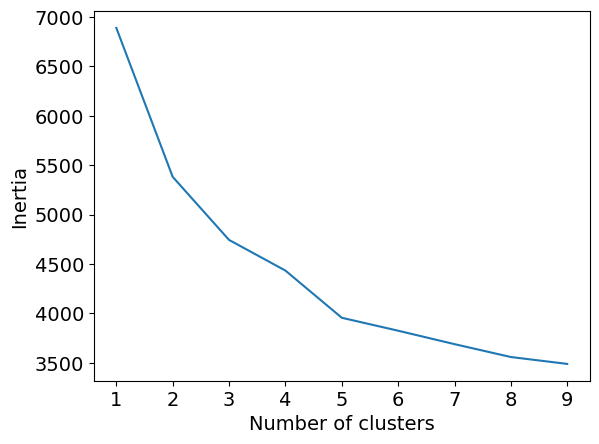

In [9]:
# Randomness will play a role in what follows, so we set a random seed for reproducibility
np.random.seed(1) 

# Let's set an elbow plot so that we know the amount of clusters we should have
elbowPlot(df, 1, 10)

Another technique that helps us determine the number of clusters is the silhouette score method. For that, we are going to compares how close data points are within a cluster and the separation between 
cluster; thist will suggest us th beste number of clusters of the dataframe.

In [11]:
def one_silhoutte(n, df):
    """
    Calculates the silhoutte score for n clusters
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters = n, n_init = 20)
    # Fit the data
    kmeans.fit(df)
    labels = kmeans.labels_
    # calculate the silhoutte score
    score = silhouette_score(df, labels)
    return score

In [13]:
best_n, best_score = None, -np.inf
for n in range(2, 11):
    score = one_silhoutte(n, df)
    if score > best_score:
        best_n = n
        best_score = score
    print(f"{n:2g} clusters silhoutte score = {score:0.2f}")
    
print(f"Best number of clusters = {best_n:2g}")

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 2 clusters silhoutte score = 0.30


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 3 clusters silhoutte score = 0.21


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 4 clusters silhoutte score = 0.16


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 5 clusters silhoutte score = 0.14


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 6 clusters silhoutte score = 0.13


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 7 clusters silhoutte score = 0.14


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 8 clusters silhoutte score = 0.13


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


 9 clusters silhoutte score = 0.12


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


10 clusters silhoutte score = 0.11
Best number of clusters =  2


Apparently, the best number of clusters is 2, according to the silhouette score method. However, the elbow method suggested us 4 clusters. Probably, the cluster of 2 elements is related with the birds' gender, and the 4 one is dividing them into seasons. Since we do not know what choice of cluster choose, we will study both. For that, we perform a cluster analysis with KMeans in 2 and 4 groups.

We could look at `perifatmass` versus `kidneyindexcorreg` as these are not too highly correlated.

In [87]:
cols = ['perifatmass', 'kidneyindexcorreg']
df_clust = df[cols].copy()
scaler = RobustScaler()
norm = scaler.fit_transform(df_clust)

def plot_fitted(cols, labels, xy, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    cmap = ListedColormap(colours)
    fig, ax = plt.subplots(dpi=144)
    s = ax.scatter(xy[:, 0], xy[:, 1], c = labels, cmap = cmap, marker = 'o', label = 'Data')
    ax.scatter(xkmeans, ykmeans, c = centre_labels, cmap = cmap, marker = 'x', s = 100, label = 'Estimated Centres')
    cbar = fig.colorbar(s, ax = ax)
    cbar.set_ticks(np.unique(labels))
    ax.legend()
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_xscale('log')
    plt.show()
    return

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


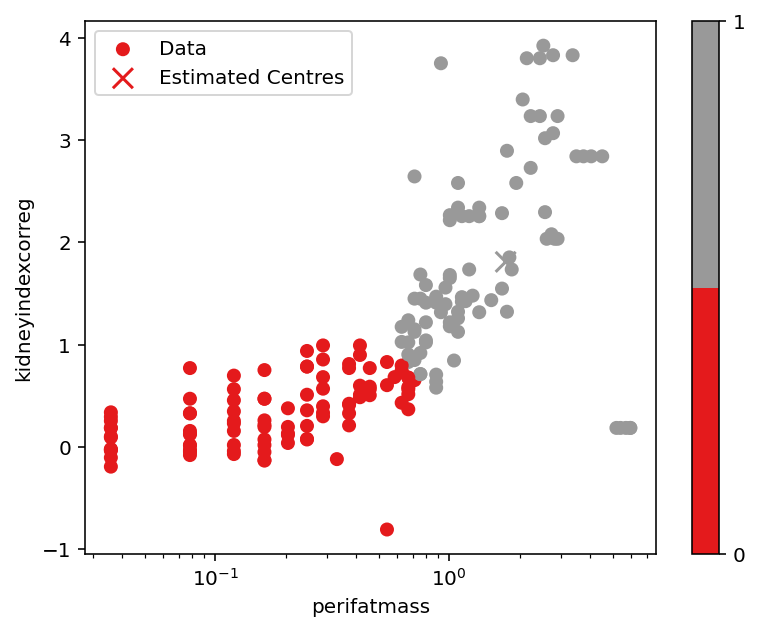

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


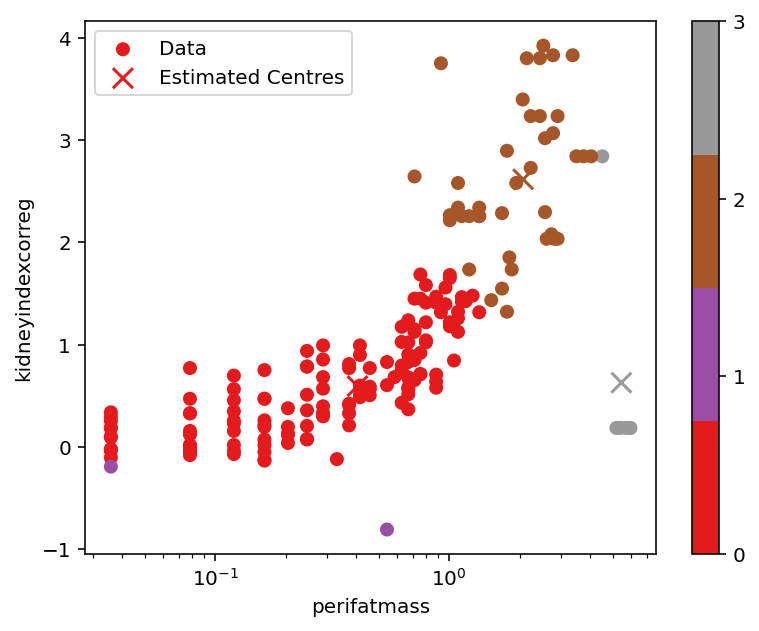

In [89]:
inv_norm = scaler.inverse_transform(norm) # this is important for plotting data accurately
for k in [2, 4]:
    kmeans = KMeans(n_clusters = k, n_init = 20)
    kmeans.fit(norm) # fit done on x,y pairs
    labels = kmeans.labels_
    # the estimated cluster centres
    cen = scaler.inverse_transform(kmeans.cluster_centers_)
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    plot_fitted(cols, labels, inv_norm, xkmeans, ykmeans, cenlabels)

After looking at the actual data, we can conclude that is better to choose 2 clusters rather than 4.!

In [106]:
def clusterAnalysis(df, n):
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(df)
    y_kmeans = kmeans.predict(df)
    df[f'Cluster{n}'] = y_kmeans
    return df[f'Cluster{n}'].value_counts()

In [107]:
clusterAnalysis(df, 2)

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cluster2
0    447
1     84
Name: count, dtype: int64

In [108]:
clusterAnalysis(df, 4)

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cluster4
0    225
2    178
3     70
1     58
Name: count, dtype: int64

In [109]:
# We will create a contingency table of Cluster2 and Cluster4 in the dataframe
pd.crosstab(df['Cluster2'], df['Cluster4'])

Cluster4,0,1,2,3
Cluster2,,,,
0,202,0,178,67
1,23,58,0,3


In [110]:
# We will create a contingency table of Cluster2 and Gender

# Change the name of the columns from Spanish to English
dfAll['sex'] = dfAll['sex'].replace({'Hembra': 'Female', 'Macho': 'Male'})

pd.crosstab(df['Cluster2'], dfAll['sex'])

sex,Female,Male
Cluster2,,
0,214,233
1,44,40


In [111]:
# There is some association, but not much. Perhaps looking at other columns will reveal more.

# Change the name of the columns from Spanish to English
dfAll['pregnant'] = dfAll['pregnant'].replace({'No preñada (lac o inact)': 'Not pregnant (lac or inact)', 'Preñada': 'Pregnant'})

pd.crosstab(df['Cluster2'], dfAll['pregnant'])

pregnant,Not pregnant (lac or inact),Pregnant
Cluster2,,
0,166,241
1,64,10


In [112]:
#Algo extraño la última columna. Tengo que preguntar que significa eso.

In [113]:
#Interesante lo de esa variable... Y si miramos sexo y preñadas con el cluster de 4?
dfAll["pregnant_sex"] = dfAll["sex"] + dfAll["pregnant"]

# Change the name of the columns from Spanish to English
dfAll['pregnant_sex'] = dfAll['pregnant_sex'].replace({'HembraNo preñada (lac o inact)': 'Female not pregnant (lac or inact)',
                                                       'HembraPreñada': 'Female pregnant',
                                                       'MachoNo preñada (lac o inact)': 'Male not pregnant (lac or inact)',
                                                       'MachoPreñada': 'Male pregnant'})

pd.crosstab(df['Cluster4'], dfAll['pregnant_sex'])

pregnant_sex,FemaleNot pregnant (lac or inact),FemalePregnant,MaleNot pregnant (lac or inact),MalePregnant
Cluster4,,,,
0,62,11,18,109
1,30,2,18,0
2,68,37,0,60
3,32,15,2,17


Apparently, Cluster2=0 splits into Cluster4=1 and 2, while Cluster2=1 divides into Cluster4=0 and 3. Let's perform a principal component analysis (PCA) to see if we can explain the separation of the clusters.

In [115]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf['Cluster2'] = df['Cluster2']
principalDf['Cluster4'] = df['Cluster4']
principalDf.head()

,PC1,PC2,Cluster2,Cluster4
0,0.634652,-0.545211,0,0
1,3.446836,0.731249,1,1
2,2.655127,-0.232193,1,0
3,3.678594,1.960607,1,1
4,2.238995,-0.290686,1,0


Let's create boxplots of the principal components according to Cluster2 and Cluster4.

In [151]:
def plot_boxplot(x, pcs, data):
    plt.figure(figsize = (10, 5))
    for i in range(len(pcs)):
        plt.subplot(1, 2, i+1)
        sns.boxplot(x = x, y = pcs[i], data = data)
        plt.xlabel(x, fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.ylabel(pcs[i], fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.subplots_adjust(wspace = 0.3)
    plt.show()

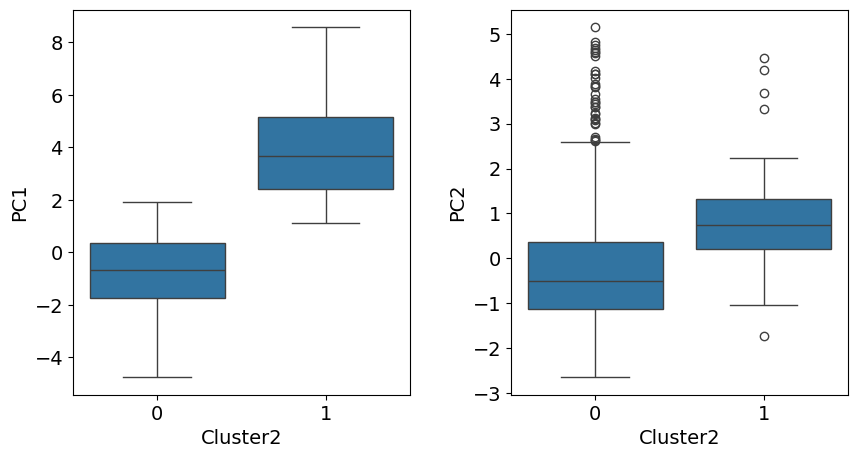

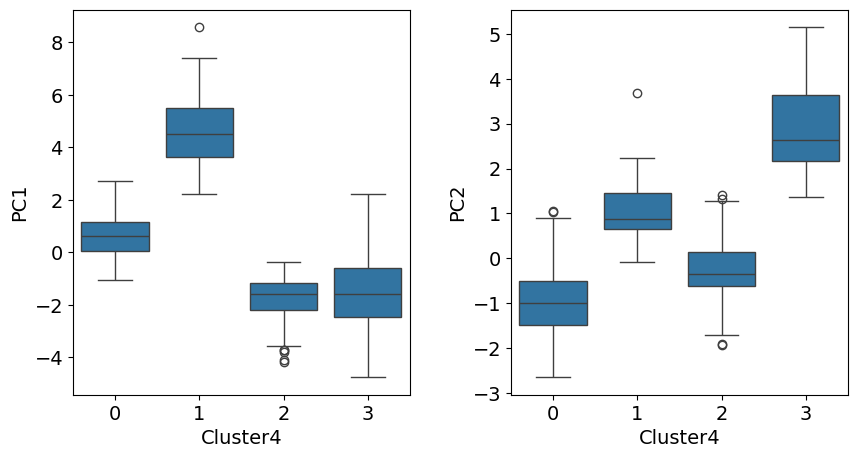

In [153]:
pcs = ['PC1', 'PC2']
plot_boxplot('Cluster2', pcs, principalDf)
plot_boxplot('Cluster4', pcs, principalDf)

It looks like PC1 is useful to separate Cluster2=0 from Cluster2=1. However, PC2 is not useful to separate Cluster2, so we can ignore it.

Also, PC1 can separate Cluster4=1 from the rest; PC2 can separte Cluster4=0 from Cluster4=2 and Cluster4=3. Therefore, observing the values of PC1 and PC2, we get a good idea of the Cluster4 to which the observation belongs.